In [0]:
# Author: Navendu Pottekkat (https://bit.ly/navendupottekkat)

import numpy as np
import matplotlib.pyplot as plt

import string
import random
import re
import requests
import os
import textwrap

In [0]:
# Create a substitution 

letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

true_mapping = {}

# Shuffle the second set of letters
random.shuffle(letters2)

# Populate true_mapping
for k,v in zip(letters1, letters2):
  true_mapping[k] = v

In [0]:
# Language model

# Initialise the Markov matrix
M = np.ones((26,26))

# Initialise state distribution
pi = np.zeros(26)

# Function to update the Markov matrix
def update_transition(ch1, ch2):
  i = ord(ch1) - 97
  j = ord(ch2) - 97
  M[i,j] += 1 

# Function to update the initial state distribution
def update_pi(ch):
  i = ord(ch) - 97
  pi[i] += 1

# Get the log-probability of a word/token
def get_word_prob(word):
  i = ord(word[0]) - 97
  logp = np.log(pi[i])

  for ch in word[1:]:
    j = ord(ch) - 97
    logp += np.log(M[i,j])
    i = j # update j
  
  return logp

# Get the probability of sequence of words
def get_sequence_prob(words):
  # if input is string, split into an array of tokens
  if type(words) == str:
    words = words.split()
  
  logp = 0
  for word in words:
    logp += get_word_prob(word)
  return logp

In [6]:
# Creating a Markov model based on the book Moby Dick
# https://lazyprogrammer.me/course_files/moby_dick.txt

# Download the file
if not os.path.exists('moby_dick.txt'):
  print("Downloading Moby Dick...")
  r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
  with open('moby_dick.txt','w') as f:
    f.write(r.content.decode())

In [0]:
# For replacing non-alpha chars

regex = re.compile('[^a-zA-Z]')

# Load in words
for line in open('moby_dick.txt'):
  line = line.rstrip()   

  # There are blank lines in the file

  if line:
    line = regex.sub(' ', line) # replace all non-alpha characters with space

    # Split the tokens in the line and lowercase
    tokens = line.lower().split()

    for token in tokens:
      # Update the model

      # First letter
      ch0 = token[0]
      update_pi(ch0)

      # Other letters
      for ch1 in token[1:]:
        update_transition(ch0,ch1)
        ch0 = ch1

# Normalise the probabilities
pi /= pi.sum()
M /= M.sum(axis=1, keepdims=True) # divide each row by row-sum

In [0]:
# Encode a message
# Excerpt taken from The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

In [0]:
# Function to encode a message
def encode_message(msg):
  msg = msg.lower() # make the message lowercase

  # Replace non-alpha characters
  msg = regex.sub(' ',msg)

  # Make the encoded message
  coded_msg = []
  for ch in msg:
    coded_ch = ch # Could be a space
    if ch in true_mapping:
      coded_ch = true_mapping[ch]
    coded_msg.append(coded_ch)
  
  return ''.join(coded_msg)

encoded_message = encode_message(original_message)

# Function to decode a message
def decode_message(msg, word_map):
  decoded_msg = []
  for ch in msg:
    decoded_ch = ch # Could be a space
    if ch in word_map:
      decoded_ch = word_map[ch]
    decoded_msg.append(decoded_ch)

  return ''.join(decoded_msg)

In [0]:
# Evolutionary algorithm to decode the message

# Initialisation point
# Creates 20 random DNA for the DNA pool to start with 
dna_pool = []
for _ in range(20):
  dna = list(string.ascii_lowercase)
  random.shuffle(dna)
  dna_pool.append(dna)

In [0]:
# Function to create offsprings
def evolve_offspring(dna_pool, n_children):
  # Make n_children per offspring
  offspring = []

  for dna in dna_pool:
    for _ in range(n_children):
      copy = dna.copy()
      j = np.random.randint(len(copy))
      k = np.random.randint(len(copy))

      # switch j and k in offspring
      tmp = copy[j]
      copy[j] = copy[k]
      copy[k] = tmp
      offspring.append(copy)
    
  return offspring + dna_pool

In [14]:
num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')

for i in range(num_iters):
  if i > 0:
    # Get offsprings from current DNA pool
    dna_pool = evolve_offspring(dna_pool, 3)
    
  # Calculate the score for each DNA
  dna2score = {}
  for dna in dna_pool:
    # populate the map
    current_map = {}
    for k,v in zip(letters1, dna):
      current_map[k] = v

    decoded_message = decode_message(encoded_message, current_map)
    score = get_sequence_prob(decoded_message)

    dna2score[''.join(dna)] = score

    # Record the best score so far

    if score > best_score:
      best_dna = dna
      best_map = current_map
      best_score = score

  # Average score for this generation
  scores[i] = np.mean(list(dna2score.values()))

  # Keep the best 5 DNA for the DNA pool
  # Turn them back to list of single chars

  sorted_dna = sorted(dna2score.items(), key=lambda x: x[1], reverse=True)
  dna_pool = [list(k) for k, v in sorted_dna[:5]]

  if i % 200 == 0:
    print("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -2115.2134929093518 best so far: -1667.296983495816
iter: 200 score: -1010.3022843339544 best so far: -933.0312453751817
iter: 400 score: -1031.7304978976686 best so far: -929.5902922650557
iter: 600 score: -1003.723861441145 best so far: -929.5902922650557
iter: 800 score: -1038.536945335505 best so far: -929.5902922650557


In [15]:
# Use the best map for deciphering the message
decoded_message = decode_message(encoded_message,best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))

# Which of the letters mapped wrong?

for true, v in true_mapping.items():
  pred = best_map[v]
  if true != pred:
    print("True: %s, Pred: %s" %(true, pred))

LL of decoded message: -929.5902922650557
LL of true message: -933.0312453751817
True: k, Pred: z
True: z, Pred: k


In [21]:
# Print the decoded message
print("True message:\n", original_message)
print("\nEncoded Message:\n", textwrap.fill(encoded_message))
print("\nDecoded Message:\n", textwrap.fill(decoded_message))

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.


Encoded Message:
 s vfak jwhkgai iwzk vfa mvxaav lki owhki  lm s anuabvai  vflv vfaxa
zlm l tazm sk l jlka zfsbf xhkm iwzk cy wka zljj wo vfa glxiak  s jakv
vfa wmvjaxm l flki sk xhccskg iwzk vfasx fwxmam  lki xabasdai sk
anbflkga vzwuakba  l gjlmm wo fljo lki fljo  vzw osjjm wo mflg vwclbbw
lki lm thbf skowxtlvswk lm s bwhji iamsxa lcwhv tsmm lijax  vw mly
kwvfskg wo fljo l iwqak wvfax uawuja sk vfa kasgfcwhxfwwi sk zfwt s
zlm kwv sk vfa jalmv skvaxamvai  chv zfwma cswgxlufsam s zl

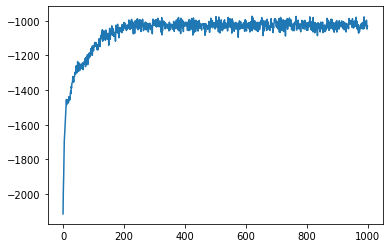

In [22]:
plt.plot(scores)
plt.show()

### Extensions:
* trigrams (Any higher N)
* replace the Markov model with deep learning RNN